In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from cvxopt import matrix, solvers
from scipy.optimize import minimize

In [2]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [5]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [6]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.004744,0.000491,0.003217,0.003817,0.008907,0.018682,0.008956,-0.009838
2005-02-01,-0.005666,-0.000115,-0.000530,-0.002013,0.006112,0.013754,0.006425,-0.003549
2005-02-02,0.004748,-0.000220,0.001214,0.005939,0.004995,0.006156,0.003192,0.002612
2005-02-03,-0.010397,-0.001690,0.000378,-0.003342,-0.007119,0.010988,-0.001758,-0.012077
2005-02-04,0.006686,0.005762,0.013300,0.005588,0.008929,0.016426,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.007921,-0.002991,-0.008365,0.018978,-0.000381,0.012039,-0.005157,0.009863
2024-12-10,-0.006082,-0.002112,-0.005163,-0.016139,-0.009207,0.002292,-0.002896,0.013155
2024-12-11,0.013895,-0.002776,-0.009999,-0.001268,0.004358,0.015587,0.007707,0.009247


Insufficient data for covariance estimation at 2005-01-31 00:00:00. Skipping rebalancing.


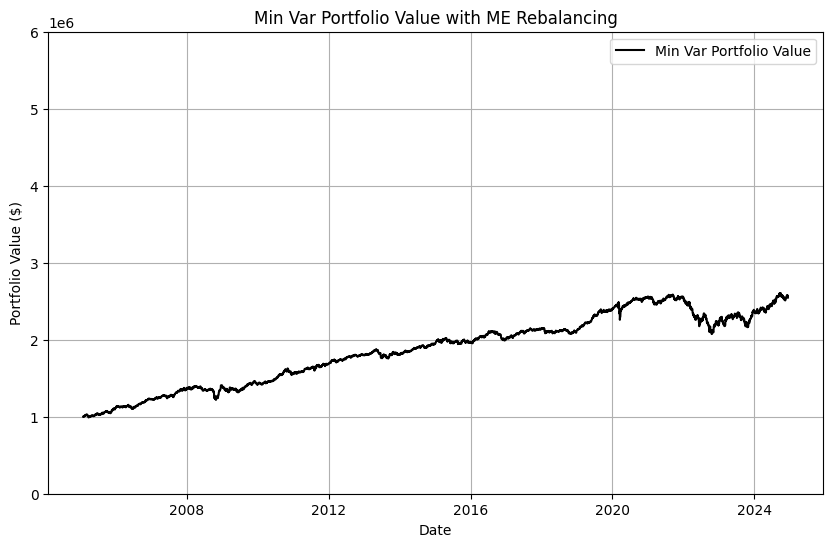

Final Portfolio Value: $2,547,258.05


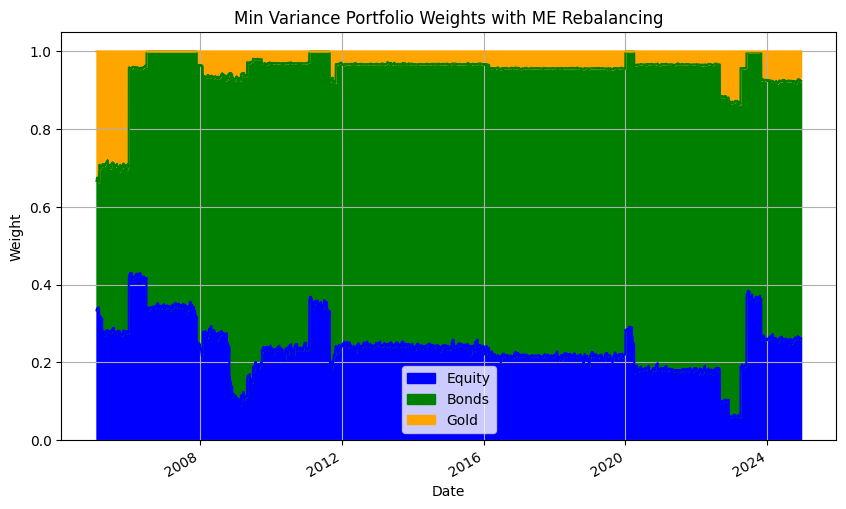

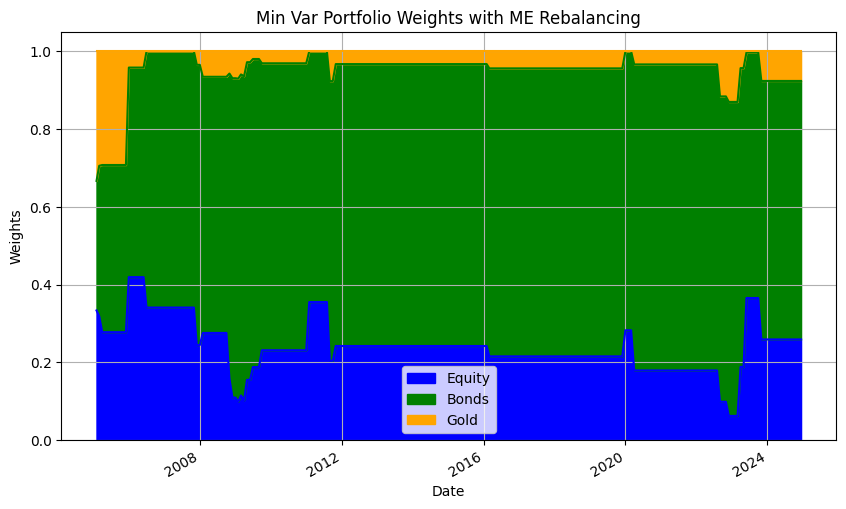

In [7]:
#### Min Var Portfolio Construction #### ver 3.0

#Variables
rebalance_frequency = 'ME'  # 'ME' = monthly, 'QE' = quarterly, 'YE' = yearly
#YE best ftol = 1e-11, ME best ftol = 1e-9
initial_investment = 1000000
lookback_days = 180
tc_rate = 0.001

# Helper Functions
def calc_portfolio_variance(w, cov_matrix):
    """Calculate portfolio variance: w^T * CovMatrix * w."""
    return np.dot(w.T, np.dot(cov_matrix, w))

def total_weight_constraint(w):
    """Constraint: weights must sum to 1."""
    return np.sum(w) - 1

def min_variance_optimizer(cov_matrix, w0, n_assets):
    """Optimize weights to minimize portfolio variance."""
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    bounds = [(0, 1)] * n_assets
    options = {'maxiter': 1000, 'ftol': 1e-9, 'disp': False}
    res = minimize(calc_portfolio_variance, w0, args=(cov_matrix,), bounds=bounds,
                   constraints=cons, method='SLSQP', options=options)
    return res

# Min Variance Portfolio Construction with Individual Asset Compounding
def min_variance_construction(returns, rebalance_frequency):
    # Define asset order and initial weights (grouping-based)
    assets = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 'APACxJapan', 'Europe', 'LatAm', 'US', 'Gold']
    returns = returns[assets]
    n_assets = len(assets)
    w0 = np.array([1/15, 1/6, 1/6, 1/15, 1/15, 1/15, 1/15, 1/3])

    # Determine rebalancing dates (aligned to trading days)
    rebal_dates = returns.resample(rebalance_frequency).last().index
    rebal_dates = returns.index[returns.index.get_indexer(rebal_dates, method='nearest')]

    # Initialize asset values, portfolio value, and portfolio weights.
    asset_vals = {asset: pd.Series(index=returns.index, dtype=float) for asset in assets}
    for asset, weight in zip(assets, w0):
        asset_vals[asset].iloc[0] = initial_investment * weight
    portfolio_val = pd.Series(index=returns.index, dtype=float)
    portfolio_val.iloc[0] = initial_investment
    portfolio_weights = pd.DataFrame(index=rebal_dates, columns=assets, dtype=float)
    if len(rebal_dates) > 0:
        portfolio_weights.iloc[0] = w0

    # Series to record transaction costs and turnover.
    tx_costs = pd.Series(0.0, index=returns.index)
    turnover_series = pd.Series(0.0, index=returns.index)

    # Loop over each rebalancing period.
    for i, rebal_date in enumerate(rebal_dates):
        prev_date = returns.index[0] if i == 0 else rebal_dates[i - 1]
        period = returns.loc[prev_date:rebal_date].index

        # Daily update: individual asset compounding.
        for t in period[1:]:
            for asset in assets:
                prev_t = period[period.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev_t] * (1 + returns[asset].loc[t])
            portfolio_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

        # Rebalancing step (if not the final period).
        if i < len(rebal_dates) - 1:
            total = portfolio_val.loc[rebal_date]

            # Estimate covariance matrix using lookback window.
            cov_start = rebal_date - pd.Timedelta(days=lookback_days)
            cov_data = returns.loc[cov_start:rebal_date]
            if cov_data.shape[0] < 2:
                print(f"Insufficient data for covariance estimation at {rebal_date}. Skipping rebalancing.")
                continue
            cov_matrix = cov_data.cov().values
            res = min_variance_optimizer(cov_matrix, w0, n_assets)
            if not res.success:
                print(f"Optimization failed at {rebal_date}. Using previous weights.")
                optimal_weights = w0
            else:
                optimal_weights = res.x
            w0 = optimal_weights  # Update for next period.
            portfolio_weights.loc[rebal_date] = w0

            # Transaction cost calculation:
            # 1. Compute target asset values based on new weights.
            target_vals = {asset: total * w for asset, w in zip(assets, w0)}
            # 2. Calculate the absolute trade required for each asset.
            trades = {asset: abs(target_vals[asset] - asset_vals[asset].loc[rebal_date]) for asset in assets}
            total_traded = sum(trades.values())
            turnover = total_traded / total
            cost = tc_rate * total_traded
            tx_costs.loc[rebal_date] = cost
            turnover_series.loc[rebal_date] = turnover

            total_adj = total - cost  # Adjust portfolio value after transaction cost.

            # Rebalance: reallocate asset values to new target allocations using the adjusted total.
            for idx, asset in enumerate(assets):
                asset_vals[asset].loc[rebal_date] = total_adj * w0[idx]
            portfolio_val.loc[rebal_date] = total_adj

    # After finishing rebalancing loop, fill missing final weights
    if portfolio_weights.iloc[-1].isna().any():
       portfolio_weights.iloc[-1] = w0  # use last computed weights

    # Update beyond final rebalancing date.
    if len(rebal_dates) > 0:
        final_rebal = rebal_dates[-1]
        period = returns.loc[final_rebal:].index
        for t in period[1:]:
            for asset in assets:
                prev_t = period[period.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev_t] * (1 + returns[asset].loc[t])
            portfolio_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)
    else:
        for t in returns.index[1:]:
            for asset in assets:
                prev_t = returns.index[returns.index.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev_t] * (1 + returns[asset].loc[t])
            portfolio_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

    return portfolio_val, portfolio_weights, asset_vals, tx_costs, turnover_series

#Function Call and Plotting
portfolio_val, portfolio_weights, asset_vals, tx_costs, turnover_series = min_variance_construction(returns, rebalance_frequency)

# Save CSV to analyze general performance
portfolio_val.name = "Portfolio"
portfolio_val.to_csv("./portfolio_csv/min_var_portfolio3.csv")

# Plot Portfolio Value
plt.figure(figsize=(10,6))
plt.plot(portfolio_val, label='Min Var Portfolio Value', color='black')
plt.title(f'Min Var Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.ylim(0, 6000000)
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Portfolio Value: ${portfolio_val.iloc[-1]:,.2f}")

# Compute daily weights for each asset
daily_weights = pd.DataFrame(index=portfolio_val.index)
for asset in asset_vals:
    daily_weights[asset] = asset_vals[asset] / portfolio_val

# Group daily weights by asset class
grouped_daily_weights = pd.DataFrame(index=daily_weights.index)
grouped_daily_weights['Equity'] = daily_weights[['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US']].sum(axis=1)
grouped_daily_weights['Bonds'] = daily_weights[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)
grouped_daily_weights['Gold'] = daily_weights['Gold']

# Plot daily asset class weights as a stacked area chart
grouped_daily_weights.plot(figsize=(10,6), kind='area', stacked=True, color=['blue','green','orange'])
plt.title(f'Min Variance Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

# (Optional) Group weights by asset class and plot.
grouped_weights = pd.DataFrame(index=portfolio_weights.index)
grouped_weights['Equity'] = portfolio_weights[['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US']].sum(axis=1)
grouped_weights['Bonds'] = portfolio_weights[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)
grouped_weights['Gold'] = portfolio_weights['Gold']
grouped_weights.plot(figsize=(10,6), kind='area', stacked=True, color=['blue','green','orange'])
plt.title(f'Min Var Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()


In [8]:
#### Min Var Portfolio Analytics #### ver 3.0

# 1) Resample portfolio value to monthly frequency and compute monthly returns
monthly_pf = portfolio_val.resample('ME').ffill()
monthly_rets = monthly_pf.pct_change().dropna()

# 2) Compute annualized volatility from monthly std deviation
annual_vol = monthly_rets.std() * np.sqrt(12)

# 3) Total return & geometric averages
initial_val = portfolio_val.iloc[0]
final_val = portfolio_val.iloc[-1]
total_ret = final_val / initial_val - 1
n_months = len(monthly_rets)
geo_avg_month = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_year = (1 + geo_avg_month) ** 12 - 1

# 4) Sharpe Ratio: annualized arithmetic return divided by annualized volatility
ann_arith_ret = monthly_rets.mean() * 12
sharpe = ann_arith_ret / annual_vol

# 5) Monthly 99% VaR (using 1st percentile)
var_99 = monthly_rets.quantile(0.01)

# 6) Portfolio Turnover: total turnover and average annual turnover
total_turnover = turnover_series.sum()
n_years = (turnover_series.index[-1] - turnover_series.index[0]).days / 365
avg_annual_turnover = total_turnover / n_years

# 7) Total transaction cost over the period
total_tx_cost = tx_costs.sum()

# 8) Print results
print("### Min Var Portfolio Analytics ###")
print(f"Annualized monthly volatility: {annual_vol:.4f}")
print(f"Total return: {total_ret * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_month * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_year * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {var_99:.4f}")
print(f"Average Annual Portfolio Turnover: {avg_annual_turnover * 100:.2f}%")
print(f"Total transaction cost over entire period: ${total_tx_cost:,.2f}")


### Min Var Portfolio Analytics ###
Annualized monthly volatility: 0.0619
Total return: 154.73%
Geometric avg monthly return (CAGR basis): 0.39%
Geometric avg yearly return (CAGR basis): 4.81%
Sharpe Ratio: 0.79
Monthly 99% Value at Risk (VaR): -0.0448
Average Annual Portfolio Turnover: 45.02%
Total transaction cost over entire period: $15,187.39


In [9]:
"""
#### Min Var Portfolio Construction #### ver 2.2

# Helper to calculate portfolio variance
def calc_portfolio_variance(w, covariance_matrix):
    # Portfolio variance = w^T * Covariance Matrix * w
    return np.dot(w.T, np.dot(covariance_matrix, w))

# Helper for weight constraint
def total_weight_constraint(w):
    return np.sum(w) - 1  # Total weights must sum to 1

# Portfolio optimization function to minimize variance
def min_variance_optimizer(cov_matrix, w0):
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    bounds = [(0, 1) for _ in range(len(returns.columns))]
    options = {'maxiter': 1000, 'ftol': 1e-11, 'disp': False}

    res = minimize(calc_portfolio_variance, w0, args=(cov_matrix,), bounds=bounds, constraints=cons, method='SLSQP', options = options)
    return res

# Main function to calculate minimum variance portfolio over time
def min_variance_construction(returns, rebalance_frequency, initial_investment=1e6):
    rebal_dates = returns.resample(rebalance_frequency).last().index
    aligned_rebal_dates = returns.index.get_indexer(rebal_dates, method='nearest')
    rebal_dates = returns.index[aligned_rebal_dates]

    portfolio_value = pd.Series(index=returns.index, dtype=float)
    portfolio_value.iloc[0] = initial_investment

    portfolio_weights = pd.DataFrame(index=rebal_dates, columns=returns.columns, dtype=float)

    n_assets = returns.shape[1]  # Expecting 8
    w0 = np.ones(n_assets) / n_assets  # initial: 1/n

    if len(rebal_dates) > 0:
        portfolio_weights.iloc[0] = w0

    # 5) Rebalancing loop
    for i in range(len(rebal_dates)):
        this_rebal_date = rebal_dates[i]

        # (A) If not the first rebal date, compute new weights:
        if i > 0:
            lookback_days = 180  # ~180 calendar days (6 months), just an example
            cov_start = this_rebal_date - pd.Timedelta(days=lookback_days)
            cov_data = returns.loc[cov_start:this_rebal_date]

            if cov_data.isna().any().any() or len(cov_data) < 2:
                print(f"Skipping rebal {this_rebal_date} due to insufficient data.")
            else:
                # Optimize min variance
                cov_matrix = cov_data.cov().values
                res = min_variance_optimizer(cov_matrix, w0)
                if not res.success:
                    print(f"Optimization failed at {this_rebal_date}")
                else:
                    optimal_weights = res.x
                    assert np.isclose(np.sum(optimal_weights), 1), "Weights do not sum to 1."
                    assert all(0 <= w <= 1 for w in optimal_weights), "Weights are out of [0,1] bounds."
                    w0 = optimal_weights
                    portfolio_weights.loc[this_rebal_date] = w0

        # Portfolio value updates
        if i == 0:
            prev_rebal_date = portfolio_value.index[0]
        else:
            prev_rebal_date = rebal_dates[i - 1]

        daily_index_slice = portfolio_value.index[(portfolio_value.index >= prev_rebal_date) & (portfolio_value.index <= this_rebal_date)]

        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)

    if len(rebal_dates) > 0:
        final_rebal = rebal_dates[-1]
        daily_index_slice = portfolio_value.loc[final_rebal:].index
        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)

    return portfolio_value, portfolio_weights

#### Actual Function Call ####

rebalance_frequency = 'ME'  # ME = monthly, QE = quarterly, YE = yearly
portfolio_value, portfolio_weights = min_variance_construction(returns, rebalance_frequency)

min_var_portfolio = portfolio_value
min_var_portfolio.rename("Portfolio", inplace=True)
min_var_portfolio.to_csv("./portfolio_csv/min_var_portfolio.csv")

# Plot the portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(min_var_portfolio, label='Min Var Portfolio Value', color='black')
plt.title(f'Min Var Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.ylim(0, 6000000)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"Final Portfolio Value: ${min_var_portfolio.iloc[-1]:,.2f}")

grouped_weights = pd.DataFrame(index=portfolio_weights.index)
grouped_weights['Equity'] = portfolio_weights[['Japan', 'APACxJapan','Europe','LatAm', 'US']].sum(axis=1)
grouped_weights['Bonds'] = portfolio_weights[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)
grouped_weights['Gold'] = portfolio_weights['Gold']

# Plot portfolio weights over time
grouped_weights.plot(figsize=(10, 6), kind='area', stacked=True, color=['blue', 'green', 'orange'])
plt.title(f'Min Var Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()
"""

'\n#### Min Var Portfolio Construction #### ver 2.2\n\n# Helper to calculate portfolio variance\ndef calc_portfolio_variance(w, covariance_matrix):\n    # Portfolio variance = w^T * Covariance Matrix * w\n    return np.dot(w.T, np.dot(covariance_matrix, w))\n\n# Helper for weight constraint\ndef total_weight_constraint(w):\n    return np.sum(w) - 1  # Total weights must sum to 1\n\n# Portfolio optimization function to minimize variance\ndef min_variance_optimizer(cov_matrix, w0):\n    cons = ({\'type\': \'eq\', \'fun\': total_weight_constraint},)\n    bounds = [(0, 1) for _ in range(len(returns.columns))]\n    options = {\'maxiter\': 1000, \'ftol\': 1e-11, \'disp\': False}\n\n    res = minimize(calc_portfolio_variance, w0, args=(cov_matrix,), bounds=bounds, constraints=cons, method=\'SLSQP\', options = options)\n    return res\n\n# Main function to calculate minimum variance portfolio over time\ndef min_variance_construction(returns, rebalance_frequency, initial_investment=1e6):\n    r

In [10]:
"""
#### Min Var Portfolio Analytics #### ver 2.2

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_minvar = portfolio_value.resample('ME').ffill()
monthly_returns_minvar = monthly_portfolio_value_minvar.pct_change().dropna()

# 2) Full sample annualized monthly volatility
full_sample_monthly_vol = monthly_returns_minvar.std()
annualized_vol = full_sample_monthly_vol * np.sqrt(12)

# 3) Total return & Geo means
initial_val = portfolio_value.iloc[0]
final_val = portfolio_value.iloc[-1]
total_return_minvar = (final_val - initial_val) / initial_val

n_months = len(monthly_returns_minvar)
geo_avg_monthly_return_minvar = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_yearly_return_minvar = (1 + geo_avg_monthly_return_minvar) ** 12 - 1

# 5) Sharpe Ratio
arithmetic_monthly_return = monthly_returns_minvar.mean()  # Arithmetic mean of monthly returns
annualized_arithmetic_return = arithmetic_monthly_return * 12  # Annualized arithmetic return
sharpe_ratio_minvar = annualized_arithmetic_return / annualized_vol

# 6) Monthly 99% VaR
VaR_99_minvar = monthly_returns_minvar.quantile(1 - 0.99)

# 7) Print results
print("### Min Var Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol:.4f}")
print(f"Total return: {total_return_minvar * 100:.2f}%")

print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_minvar * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_minvar * 100:.2f}%")

print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_minvar:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_minvar:.4f}")
"""

'\n#### Min Var Portfolio Analytics #### ver 2.2\n\n# 1) Resample to monthly frequency and calculate monthly returns\nmonthly_portfolio_value_minvar = portfolio_value.resample(\'ME\').ffill()\nmonthly_returns_minvar = monthly_portfolio_value_minvar.pct_change().dropna()\n\n# 2) Full sample annualized monthly volatility\nfull_sample_monthly_vol = monthly_returns_minvar.std()\nannualized_vol = full_sample_monthly_vol * np.sqrt(12)\n\n# 3) Total return & Geo means\ninitial_val = portfolio_value.iloc[0]\nfinal_val = portfolio_value.iloc[-1]\ntotal_return_minvar = (final_val - initial_val) / initial_val\n\nn_months = len(monthly_returns_minvar)\ngeo_avg_monthly_return_minvar = (final_val / initial_val) ** (1 / n_months) - 1\ngeo_avg_yearly_return_minvar = (1 + geo_avg_monthly_return_minvar) ** 12 - 1\n\n# 5) Sharpe Ratio\narithmetic_monthly_return = monthly_returns_minvar.mean()  # Arithmetic mean of monthly returns\nannualized_arithmetic_return = arithmetic_monthly_return * 12  # Annualize